In [1]:
import numpy as np
import random
import os

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential


import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

# Part 1 - Data Preprocessing

## Split into train , test data

In [2]:
# train, test split
splitfolders.ratio('./data/humanModel/imagesDatabase/', output="./data/humanModel/imagesDatabase_split", ratio=(0.7, 0.3))

Copying files: 6429 files [00:00, 13623.50 files/s]


### Preprocessing the Training set

In [3]:
batch_size = 64
img_height = 10
img_width = 10

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './data/humanModel/imagesDatabase_split/train',
  seed=rs,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './data/humanModel/imagesDatabase_split/val',
  seed=rs,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

2021-11-25 12:56:14.557528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 12:56:14.562062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 12:56:14.562392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Found 4498 files belonging to 5 classes.
Found 1931 files belonging to 5 classes.
['32', '37', '38', '39', '40']


2021-11-25 12:56:14.563355: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-25 12:56:14.563772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 12:56:14.564102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 12:56:14.564405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## View some data

2021-11-25 12:56:15.105590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


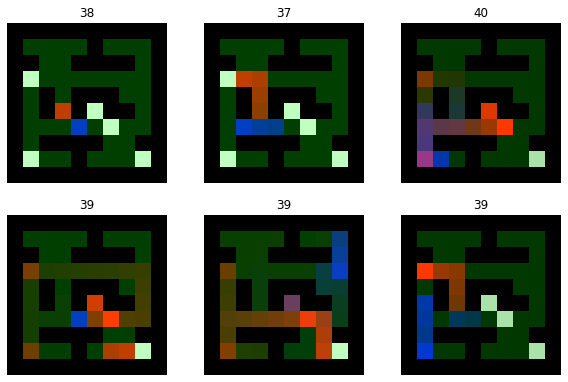

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Flatten(),
  # layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  # layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes, activation='softmax')
])

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 10, 10, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 8)         392       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2064      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 8)           1160      
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0

In [9]:
epochs=150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/150


/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2021-11-25 12:56:16.089761: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300


71/71 [==============================] - 1s 4ms/step - loss: 1.6405 - accuracy: 0.2570 - val_loss: 1.5696 - val_accuracy: 0.2796
Epoch 2/150
71/71 [==============================] - 0s 2ms/step - loss: 1.4575 - accuracy: 0.3960 - val_loss: 1.2794 - val_accuracy: 0.5028
Epoch 3/150
71/71 [==============================] - 0s 2ms/step - loss: 1.2753 - accuracy: 0.5069 - val_loss: 1.1712 - val_accuracy: 0.5748
Epoch 4/150
71/71 [==============================] - 0s 2ms/step - loss: 1.2239 - accuracy: 0.5420 - val_loss: 1.1005 - val_accuracy: 0.6106
Epoch 5/150
71/71 [==============================] - 0s 2ms/step - loss: 1.1456 - accuracy: 0.5725 - val_loss: 1.0555 - val_accuracy: 0.6168
Epoch 6/150
71/71 [==============================] - 0s 3ms/step - loss: 1.1118 - accuracy: 0.5851 - val_loss: 1.0289 - val_accuracy: 0.6359
Epoch 7/150
71/71 [==============================] - 0s 2ms/step - loss: 1.0874 - accuracy: 0.5954 - val_loss: 1.0062 - val_accuracy: 0.6515
Epoch 8/150
71/71 [======

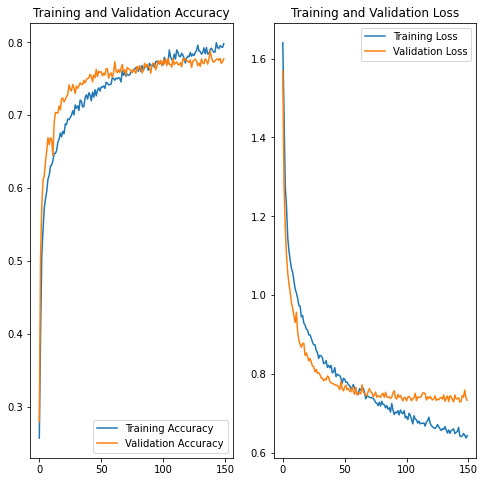

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

31/31 [==============================] - 0s 943us/step - loss: 0.7333 - accuracy: 0.7773
Test accuracy : 0.777317464351654


In [12]:
# Save the entire model as a SavedModel.
# model.save('./data/humanModel/mode_v0')
model.save('./data/humanModel/model_v0.h5')

In [13]:
# save model in js format
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [14]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [15]:
sunflower_path = "./data/humanModel/imagesDatabase_split/val/39/-MpIqdos7xbOmReSEoMh_10.png"

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 39 with a 38.79 percent confidence.
